In [1]:
import os
import pickle
import gzip
import numpy as np
import pandas as pd

import tensorflow as tf
#tf.enable_eager_execution()

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
from matplotlib import pyplot as plt
%matplotlib inline
from werdich_cfr.tfutils.TFRprovider import DatasetProvider
from werdich_cfr.utils.visuals import ImageSliceViewer3D

### Recover data from TFRecords: look at the postprocessed images ###

In [2]:
# Directories and files
cfr_data_root = os.path.normpath('/mnt/obi0/andreas/data/cfr')
meta_date = '200202'
tfr_dir = os.path.join(cfr_data_root, 'tfr_'+meta_date)
meta_dir = os.path.join(cfr_data_root, 'metadata_'+meta_date)

# TFR file
tfr_file = os.path.join(tfr_dir, 'CFR_200202_view_a4c_test_0.tfrecords')
parquet_file = os.path.join(tfr_dir, 'CFR_200202_view_a4c_test_0.parquet')

# Load df 
df = pd.read_parquet(parquet_file)
df.head(2)

,mrn,study,echo_study_date,reportID,days_post_cfr,subjectid,report_number,cfr_study_date,cfr_report_date,cfr,filename,dir,datetime,fileid,institution,model,manufacturer,frame_time,number_of_frames,heart_rate,deltaX,deltaY,view_a2c,view_a3c,view_a4c,view_plax,view_psax,view_other,max_view,dset,rate
8006,20915880,4903add984df300f_4903a581a72a3bb34bc3ef51c3dd,2014-01-29,134909,-259,5786,EVS0459826,2014-10-15,2014-01-29,2.404288,4903add984df300f_4903a581a72a3bb34bc3ef51c3dd_...,/mnt/obi0/phi/echo/npyFiles/BWH/4903/4903add98...,2014-01-29 10:02:32,4903add984df300f_4903a581a72a3bb34bc3ef51c3dd_...,BWH,iE33,Philips Medical Systems,33.333000,57.0,65.0,0.035327,0.035327,7.208254e-05,3.741998e-11,0.999914,1.023750e-08,1.344264e-05,1.041682e-08,view_a4c,test,30.0
111988,6158190,4b7d757fa70a2162_4903a585855e2e2cdddae1b0e3a3,2010-10-06,106017,0,3796,EVS0266507,2010-10-06,2010-10-06,2.488095,4b7d757fa70a2162_4903a585855e2e2cdddae1b0e3a3_...,/mnt/obi0/phi/echo/npyFiles/BWH/4b7d/4b7d757fa...,2010-10-06 10:17:03,4b7d757fa70a2162_4903a585855e2e2cdddae1b0e3a3_...,BWH,Vivid7,GE Vingmed Ultrasound,36.296297,55.0,68.0,0.056266,0.056266,2.008689e-09,1.254592e-09,1.000000,6.082250e-09,1.609704e-07,6.054661e-08,view_a4c,test,27.6


### Percentile thresholds for classification ###

In [3]:
# Get the percentile thresholds for the data we have
dset_filename = 'tfr_files_dset_BWH_'+meta_date+'.parquet'
df_cfr = pd.read_parquet(os.path.join(meta_dir, dset_filename))
print('Size of cfr table:', df_cfr.shape)
cfr_array = df_cfr.cfr.values
p_list = [np.round(np.percentile(cfr_array, p), decimals = 3) for p in (25, 50, 75)]
print('Percentile boundaries:', p_list)

Size of cfr table: (131282, 31)
Percentile boundaries: [1.247, 1.583, 2.075]


In [4]:
p_list = [np.round(np.percentile(cfr_array, p), decimals = 3) for p in (25, 50, 75)]
percentile_list = sorted(p_list)
print('Percentile boundaries:', p_list)

Percentile boundaries: [1.247, 1.583, 2.075]


In [5]:
def cfr_label(cfr_value):
    if cfr_value < percentile_list[0]:
        label = 0
    elif cfr_value >= percentile_list[-1]:
        label = len(percentile_list)
    
    for p in range(1, len(percentile_list)):
        
        if (cfr_value >= percentile_list[p-1]) & (cfr_value < percentile_list[p]):
            label = p
    
    return label

df['label'] = df['cfr'].apply(cfr_label)
print(df.label.iloc[0:10].values)

[3 3 2 2 0 2 1 1 3 3]


In [6]:
percentile_list = p_list
def cfr_p_label(cfr_value):
    return np.digitize(cfr_value, bins = percentile_list)
# Setting the threshold, check the number of positives and negatives
df['labelp'] = df['cfr'].apply(cfr_p_label)
print(df.labelp.iloc[0:10].values)

[3 3 2 2 0 2 1 1 3 3]


In [7]:
label_list = sorted(df.label.unique())
print('Unique labels:', label_list)
df.head(20)
# Number of samples in each group
samples = [df[df.label == l].shape[0] for l in label_list]
for l in label_list:
    print('Label:', l, 'samples:', samples[l])

Unique labels: [0, 1, 2, 3]
Label: 0 samples: 420
Label: 1 samples: 435
Label: 2 samples: 484
Label: 3 samples: 441


In [8]:
tfr_file

'/mnt/obi0/andreas/data/cfr/tfr_200202/CFR_200202_view_a4c_test_0.tfrecords'

In [26]:
# Load from tfrecords
ds = DatasetProvider([tfr_file],
                     repeat_count = 1,
                     n_frames = 30,
                     cfr_boundaries = p_list,
                     output_height = 299,
                     output_width = 299,
                     record_output = True,
                     im_resize_crop=False)

batch_size = 8
ds = ds.make_batch(batch_size = batch_size, shuffle = False)

In [27]:
df.index

Int64Index([  8006, 111988, 111732,  72466,  67016, 127810,  24840, 115236,  95615,  70336,
            ...
             55305, 102808,  66000, 120226,  30250,  84555,  93018,  98913,  24772, 120200], dtype='int64', length=1780)

In [28]:
for out in ds.take(1):
    output_batch = out
    

# Output batch is a list of dictionaries [INPUT, OUTPUT]:
print('Input keys: ', output_batch[0].keys())
print('Output keys:', output_batch[1].keys())

image_batch = output_batch[0]['video'].numpy()
print('Video batch shape:', image_batch.shape)
class_label_batch = output_batch[1]['class_output'].numpy()
print('Class batch output shape:', class_label_batch.shape)
cfr_batch = output_batch[1]['score_output'].numpy()
print('CFR batch output shape:', cfr_batch.shape)
record_batch = output_batch[2]['record'].numpy()
print('Record:', record_batch)
print('CFR', cfr_batch)

df[df.index.isin(record_batch)]

Input keys:  dict_keys(['video'])
Output keys: dict_keys(['class_output', 'score_output'])
Video batch shape: (8, 30, 299, 299, 1)
Class batch output shape: (8, 4)
CFR batch output shape: (8,)
Record: [  8006 111988 111732  72466  67016 127810  24840 115236]
CFR [2.4042876 2.4880948 1.5994316 2.0663562 0.870137  1.6426485 1.4246912
 1.5637584]


,mrn,study,echo_study_date,reportID,days_post_cfr,subjectid,report_number,cfr_study_date,cfr_report_date,cfr,filename,dir,datetime,fileid,institution,model,manufacturer,frame_time,number_of_frames,heart_rate,deltaX,deltaY,view_a2c,view_a3c,view_a4c,view_plax,view_psax,view_other,max_view,dset,rate,label,labelp
8006,20915880,4903add984df300f_4903a581a72a3bb34bc3ef51c3dd,2014-01-29,134909,-259,5786,EVS0459826,2014-10-15,2014-01-29,2.404288,4903add984df300f_4903a581a72a3bb34bc3ef51c3dd_...,/mnt/obi0/phi/echo/npyFiles/BWH/4903/4903add98...,2014-01-29 10:02:32,4903add984df300f_4903a581a72a3bb34bc3ef51c3dd_...,BWH,iE33,Philips Medical Systems,33.333000,57.0,65.0,0.035327,0.035327,7.208254e-05,3.741998e-11,0.999914,1.023750e-08,1.344264e-05,1.041682e-08,view_a4c,test,30.0,3,3
111988,6158190,4b7d757fa70a2162_4903a585855e2e2cdddae1b0e3a3,2010-10-06,106017,0,3796,EVS0266507,2010-10-06,2010-10-06,2.488095,4b7d757fa70a2162_4903a585855e2e2cdddae1b0e3a3_...,/mnt/obi0/phi/echo/npyFiles/BWH/4b7d/4b7d757fa...,2010-10-06 10:17:03,4b7d757fa70a2162_4903a585855e2e2cdddae1b0e3a3_...,BWH,Vivid7,GE Vingmed Ultrasound,36.296297,55.0,68.0,0.056266,0.056266,2.008689e-09,1.254592e-09,1.000000,6.082250e-09,1.609704e-07,6.054661e-08,view_a4c,test,27.6,3,3
111732,5935507,4b7e40869de6303a_4903a581a729165aa2617b1f1913,2014-02-10,128542,55,5756,EVS0465688,2013-12-17,2014-02-10,1.599432,4b7e40869de6303a_4903a581a729165aa2617b1f1913_...,/mnt/obi0/phi/echo/npyFiles/BWH/4b7e/4b7e40869...,2014-02-10 11:30:11,4b7e40869de6303a_4903a581a729165aa2617b1f1913_...,BWH,iE33,Philips Medical Systems,33.333000,65.0,59.0,0.028706,0.028706,2.344970e-10,2.540582e-10,1.000000,2.016242e-11,9.736658e-11,1.218168e-09,view_a4c,test,30.0,2,2
72466,24357550,4907ba5bcb859347_4903a5864e62c368b1899c3e9277,2013-04-24,123775,-2,5237,EVS0430176,2013-04-26,2013-07-14,2.066356,4907ba5bcb859347_4903a5864e62c368b1899c3e9277_...,/mnt/obi0/phi/echo/npyFiles/BWH/4907/4907ba5bc...,2013-04-24 08:35:08,4907ba5bcb859347_4903a5864e62c368b1899c3e9277_...,BWH,iE33,Philips Medical Systems,33.333000,46.0,83.0,0.048410,0.048410,1.182036e-12,5.252439e-11,1.000000,6.277198e-12,1.334326e-11,1.871121e-10,view_a4c,test,30.0,2,2
67016,14527550,4a12b407dc4f854f_4903a585842f401bedf622574877,2010-01-19,107888,-364,3987,EVS0284054,2011-01-18,2011-01-18,0.870137,4a12b407dc4f854f_4903a585842f401bedf622574877_...,/mnt/obi0/phi/echo/npyFiles/BWH/4a12/4a12b407d...,2010-01-19 09:15:00,4a12b407dc4f854f_4903a585842f401bedf622574877_...,BWH,iE33,Philips Medical Systems,33.333000,52.0,74.0,0.037555,0.037555,3.065661e-12,1.792938e-15,1.000000,1.158044e-14,7.293039e-14,1.889846e-14,view_a4c,test,30.0,0,0
127810,15715683,4a13446cce5ff451_4903a58051d59d43341bc2568568,2015-11-02,146627,-199,5093,E1519007,2016-05-19,2016-05-19,1.642648,4a13446cce5ff451_4903a58051d59d43341bc2568568_...,/mnt/obi0/phi/echo/npyFiles/BWH/4a13/4a13446cc...,2015-11-02 10:20:30,4a13446cce5ff451_4903a58051d59d43341bc2568568_...,BWH,EPIQ 7C,Philips Medical Systems,33.333000,61.0,101.0,0.036490,0.036490,7.899399e-07,5.596539e-07,0.999848,9.868662e-05,8.646753e-06,4.272278e-05,view_a4c,test,30.0,2,2
24840,2415545,4b79c94086090f25_4903a58792a1e7a6d4481621f48b,2012-10-01,119823,-2,5124,EVS0400775,2012-10-03,2013-06-24,1.424691,4b79c94086090f25_4903a58792a1e7a6d4481621f48b_...,/mnt/obi0/phi/echo/npyFiles/BWH/4b79/4b79c9408...,2012-10-01 14:50:15,4b79c94086090f25_4903a58792a1e7a6d4481621f48b_...,BWH,iE33,Philips Medical Systems,33.333000,61.0,60.0,0.036475,0.036475,1.442935e-12,2.575434e-15,1.000000,1.736809e-14,6.633172e-12,3.632279e-14,view_a4c,test,30.0,1,1
115236,9433152,4b72978d0cf99c24_4903a44ab129eff572375180067b,2009-02-17,90709,174,2537,EVS0170057,2008-08-27,2009-02-17,1.563758,4b72978d0cf99c24_4903a44ab129eff572375180067b_...,/mnt/obi0/phi/echo/npyFiles/BWH/4b72/4b72978d0...,2009-02-17 15:28:19,4b72978d0cf99c24_4903a44ab129eff572375180067b_...,BWH,Vivid7,GE Vingmed Ultrasound,40.163400,52.0,91.0,0.056266,0.056266,2.744269e-08,6.607036e-09,0.999975,2.548225

In [29]:
output_batch[0]['video'].shape

TensorShape([8, 30, 299, 299, 1])

In [30]:
# Pick a random sample from the batch
#sample_idx = np.random.randint(batch_size, size = 1)[0]
sample_idx = 1

# Image sample
video_sample = image_batch[sample_idx]
class_label_onehot = class_label_batch[sample_idx]
class_label = np.argmax(class_label_onehot)

print('Batch sample:', sample_idx)
print('Video shape:', video_sample.shape)
print('class label:', class_label)

#Pick a few images and check the stats
image_idx_list = np.random.randint(video_sample.shape[0], size = 10)
for frame in image_idx_list:
    im = video_sample[frame]
    print()
    print('frame:', frame)
    print('min:', np.amin(im))
    print('max:', np.amax(im))
    print('mean:', np.mean(im))
    print('std:', np.std(im))
    print('color channels:', im[20, 20, :])

Batch sample: 1
Video shape: (30, 299, 299, 1)
class label: 3

frame: 4
min: -0.4070459008216858
max: 8.940255165100098
mean: -5.609928832375401e-07
std: 1.0000003878044852
color channels: [-0.4070459]

frame: 3
min: -0.4116380512714386
max: 9.151537895202637
mean: 1.1061234970476137e-06
std: 0.9999988708535306
color channels: [-0.41163805]

frame: 21
min: -0.40351614356040955
max: 9.249008178710938
mean: -6.5523220735381e-07
std: 1.0000006633667882
color channels: [-0.40351614]

frame: 14
min: -0.4066105782985687
max: 9.177675247192383
mean: 5.574170650020767e-07
std: 1.0000001877732607
color channels: [-0.40661058]

frame: 20
min: -0.4054489731788635
max: 9.528984069824219
mean: 1.0256983937120017e-06
std: 1.000000085461608
color channels: [-0.40544897]

frame: 10
min: -0.40236037969589233
max: 9.195328712463379
mean: -1.5286286895714586e-07
std: 0.999998961981511
color channels: [-0.40236038]

frame: 5
min: -0.4048379063606262
max: 9.294438362121582
mean: 4.322389183807438e-07
std: 

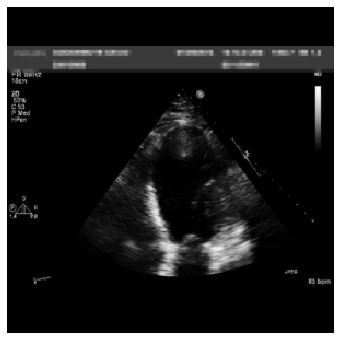

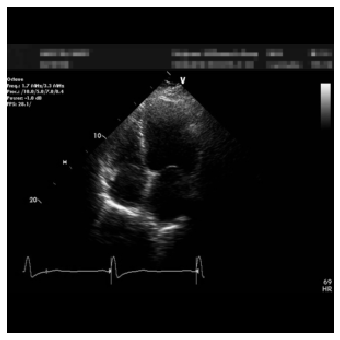

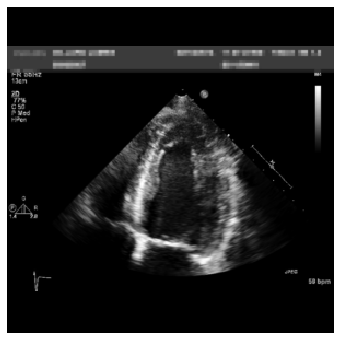

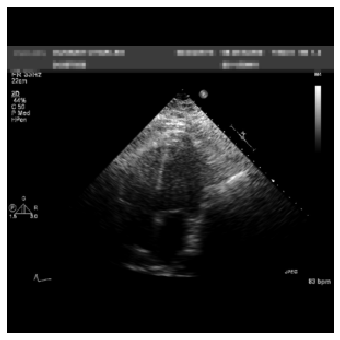

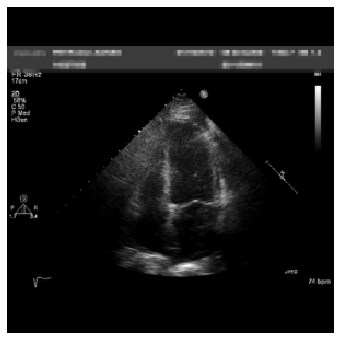

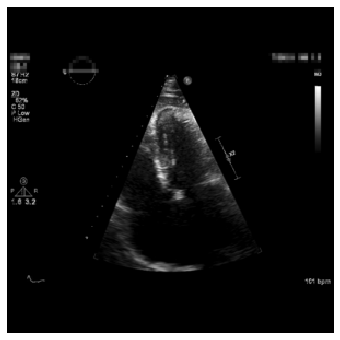

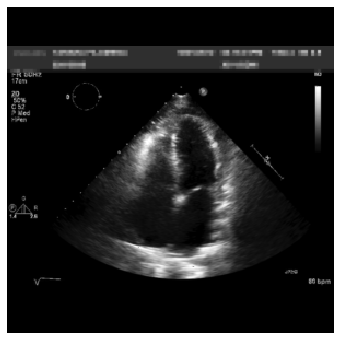

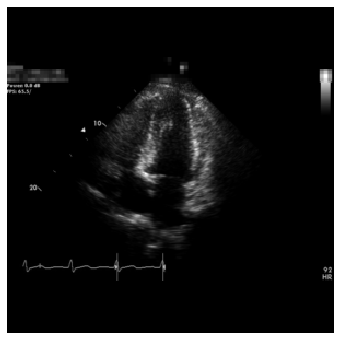

In [31]:
# Let's take a look at one of the videos
# Pick a random sample from the batch
frame = 5
save_dir = os.path.join(cfr_data_root, 'proc_test', 'im_resize_pad')


for sample in range(len(output_batch[0]['video'])):
    im_array = np.squeeze(output_batch[0]['video'][sample])
    im_array = np.moveaxis(im_array, 0, -1)
    im = im_array[:, :, frame]
    fig, ax = plt.subplots(figsize = (6, 6))
    ax.imshow(im, cmap = 'gray')
    plt.axis('off')
    save_file = os.path.join(save_dir, 'video_'+str(sample)+'.png')
    plt.savefig(save_file, bbox_inches='tight')